# Task

Operators like joins, selections and missing value imputaters can cause *data distribution issues*, which can heavily impact the performance of our model. Mlinspect helps with identifying such issues by offering an inspection to calculate historams for sensitive groups. Thanks to our annotation propagation, this works even if the group columns are projected out at some point. To automatically check for significant changes and compute the histograms, we used the `no_bias_introduced_for(...)` constraint.

We want to find out if preprocessing operations in this pipeline introduce bias and if so, which groups are effected.
The pipeline we want to analyse can be found using the path `os.path.join(str(get_project_root()), "example_pipelines", "adult_easy", "adult_easy.py")
`. Its code:

> ```python
> import os
> import pandas as pd
> 
> from sklearn import compose, preprocessing, tree, pipeline
> from mlinspect.utils import get_project_root
> 
> print('pipeline start')
> train_file = os.path.join(str(get_project_root()), "example_pipelines", "adult_complex", "adult_train.csv")
> raw_data = pd.read_csv(train_file, na_values='?', index_col=0)
> 
> data = raw_data.dropna()
> 
> labels = preprocessing.label_binarize(data['income-per-year'], classes=['>50K', '<=50K'])
> 
> feature_transformation = compose.ColumnTransformer(transformers=[
>     ('categorical', preprocessing.OneHotEncoder(handle_unknown='ignore'), ['education', 'workclass']),
>     ('numeric', preprocessing.StandardScaler(), ['age', 'hours-per-week'])
> ])
> 
> 
> income_pipeline = pipeline.Pipeline([
>     ('features', feature_transformation),
>     ('classifier', tree.DecisionTreeClassifier())])
> 
> income_pipeline.fit(data, labels)
> print('pipeline finished')
> 
> ```

 This is using a benchmark dataset frequently used in the algorithmic fairness literature. `Adult income` contains information about 33,000 individuals from the 1994 U.S. census, with sensitive attributes gender and race. The corresponding task is to predict whether the annual income of an individual exceeds $50,000. 

In [5]:
train_file = os.path.join(str(get_project_root()), "example_pipelines", "adult_complex", "adult_train.csv")
raw_data = pd.read_csv(train_file, na_values='?', index_col=0)

In [22]:
import numpy
raw_data

raw_data["id"] = range(0, len(raw_data))

raw_data_a = raw_data[["id", "age", "workclass", "fnlwgt", "education", "education-num"]]
raw_data_b = raw_data[["id", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", 
                       "capital-loss", "hours-per-week", "native-country", "income-per-year"]]
# Remove some rows from join result   
raw_data_b_female = raw_data_b[raw_data_b['sex'] == 'Female'].index.values    
numpy.random.shuffle(raw_data_b_female)    
n = int(len(raw_data_b_female) * 0.4)
raw_data_b.loc[raw_data_b_female[:n],'id'] = None

merge_test = raw_data_a.merge(raw_data_b, on="id")
merge_test

ADULT_SIMPLE_DATA_A = os.path.join(str(get_project_root()), "experiments", "user_interviews",
                                    "adult_simple_train_a.csv")
ADULT_SIMPLE_DATA_B = os.path.join(str(get_project_root()), "experiments", "user_interviews",
                                    "adult_simple_train_b.csv")

raw_data_a.to_csv(ADULT_SIMPLE_DATA_A, index=True)
raw_data_b.to_csv(ADULT_SIMPLE_DATA_B, index=True)

# Step 1/4: Add check and execute the pipeline

The central entry point of mlinspect is the `PipelineInspector`. To use mlinspect, we use it and pass it the path to the runnable version of the example pipeline. Here, we have the example pipeline in a `.py` file. 

First, we define the check we want mlinspect to run. In this example, we only use 1 check to compute histograms of sensitive groups and verify operators cause no significant distribution changes.

Then, we execute the pipeline. Mlinspect returns a `InspectorResult`, which contains the output of our check. 

In [24]:
import os
from mlinspect.utils import get_project_root

from mlinspect import PipelineInspector
from mlinspect.checks import NoBiasIntroducedFor

HEALTHCARE_FILE_PY = os.path.join(str(get_project_root()), "experiments", "user_interviews", "adult_simple_modified.py")

inspector_result = PipelineInspector\
    .on_pipeline_from_py_file(HEALTHCARE_FILE_PY) \
    .add_check(NoBiasIntroducedFor(["race", "sex"])) \
    .execute()

check_results = inspector_result.check_to_check_results

pipeline start
pipeline finished


# Step 2/4: Overview of the check results
## Did our check find issues?

Let us look at the `check_result` to see whether some checks failed. We see that some issue was found, so we have to investigate it.

In [25]:
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

check_result_df = PipelineInspector.check_results_as_data_frame(check_results)
display(check_result_df)

,check_name,status,description
0,"NoBiasIntroducedFor((('race', 'sex'), -0.3))",CheckStatus.FAILURE,"A Join causes a min_relative_ratio_change of 'sex' by -0.30857378313218065, a value below the configured minimum threshold -0.3!"


# Step 3/4: List of operations that could change the distribution 

As stated before, only some operations like selections, joins and missing value imputation can change the distribution. Our check already filtered all operators that can cause data distribution issues. Now we will use the result to create list with all distribution changes and visualize them. Using this, we can investigate the changes of the different operators one at a time.

In [26]:
no_bias_check_result = check_results[NoBiasIntroducedFor(["race", "sex"])]

distribution_changes_overview_df = NoBiasIntroducedFor.get_distribution_changes_overview_as_df(no_bias_check_result)
display(distribution_changes_overview_df)

dag_node_distribution_changes_list = list(no_bias_check_result.bias_distribution_change.items())

,DagNode OperatorType,DagNode CodeReference,DagNode Module,DagNode Description,'race' distribution change below the configured minimum test threshold,'sex' distribution change below the configured minimum test threshold
0,OperatorType.JOIN,"CodeReference(lineno=18, col_offset=11, end_lineno=18, end_col_offset=48)","(pandas.core.frame, merge)",on id,False,True
1,OperatorType.SELECTION,"CodeReference(lineno=20, col_offset=7, end_lineno=20, end_col_offset=24)","(pandas.core.frame, dropna)",dropna,False,False


# Step 4/4 Detailed Investigation

We start by looking at the first operator that could heavily change the proportion of groups in our data, the `.dropna()` selection. Then, ...

 OperatorType.JOIN CodeReference(lineno=18, col_offset=11, end_lineno=18, end_col_offset=48) ('pandas.core.frame', 'merge') on id 

 Column 'race', acceptable change: True, min_relative_ratio_change: -0.07668212923401617


,sensitive_column_value,count_before,count_after,ratio_before,ratio_after,relative_ratio_change
0,Amer-Indian-Eskimo,218,183,0.009565,0.009252,-0.032723
1,Asian-Pac-Islander,737,632,0.032336,0.031951,-0.011889
2,Black,2154,1726,0.094507,0.087260,-0.076682
3,Other,197,164,0.008643,0.008291,-0.040746
4,White,19486,17075,0.854949,0.863246,0.009704


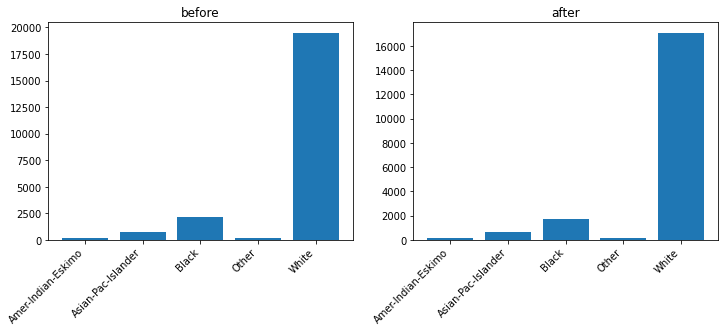


 Column 'sex', acceptable change: False, min_relative_ratio_change: -0.30857378313218065


,sensitive_column_value,count_before,count_after,ratio_before,ratio_after,relative_ratio_change
0,Female,7531,4519,0.330423,0.228463,-0.308574
1,Male,15261,15261,0.669577,0.771537,0.152275


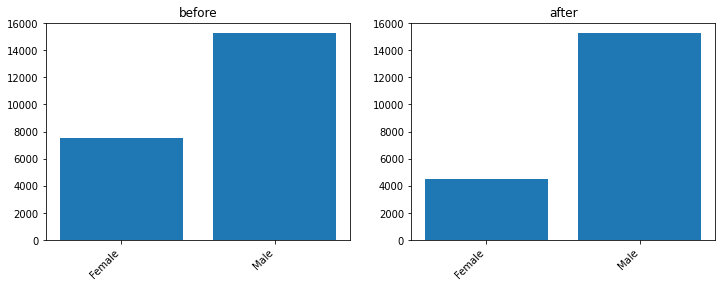

In [27]:
# Select the DagNode we want to look at by index
selection, selection_distribution_changes = dag_node_distribution_changes_list[0]

# Investige the changes
print('\033[1m', selection.operator_type, selection.code_reference, selection.module, selection.description, '\033[0m')
for column, distribution_change in selection_distribution_changes.items():
    print("")
    print("\033[1m Column '{}'\033[0m, acceptable change: {}, min_relative_ratio_change: {}".format(column, distribution_change.acceptable_change, distribution_change.min_relative_ratio_change))
    display(distribution_change.before_and_after_df)
    NoBiasIntroducedFor.plot_distribution_change_histograms(distribution_change)

# Solution: Did we find operators that introduce bias? How much did the distribution change?

**TODO:** ...